<a href="https://colab.research.google.com/github/ee-689-boun/tsdl/blob/main/gluonts2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I implemented some of models we mentioned, namely **DeepAR**, **DeepState**, **DeepFactor** (we did not mention this, I found them on the documentation) and a **simple feed forward network**. I finished with the comparison of the methods with the selected metrics, MAPE and RMSE - can be easily increased - 

Other available models can be found here:
https://ts.gluon.ai/api/gluonts/gluonts.model.html

#### Notes:

- Some models like deepstate can work with multiple items at the same time, so maybe we can add pound/usd or jpy/eur etc. to see whether they improve the performance or not.
- I played with the hyperparameters but I think we need to analyze them more. And to keep the running fast, I selected small numbers of epochs. I think we have to increase them before the report. 
- We can run classic time series model that are implemented in R from gluonts library, but I couldn't succeed. 

#### References:
- https://aws.amazon.com/tr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/
- https://ts.gluon.ai/#get-started-a-quick-example

In [1]:
!pip install mxnet gluonts
!pip uninstall statsmodels -y && pip install statsmodels

# installing R packages, requires for GluonTS R wrapper, but I couldn't make it work, so for now no need to install
# !pip install 'rpy2>=2.9.*,<3.*'
# !R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

     |████████████████████████████████| 54.7MB 78kB/s 
     |████████████████████████████████| 573kB 40.0MB/s 
     |████████████████████████████████| 8.7MB 35.6MB/s 
     |████████████████████████████████| 194kB 41.8MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68032 sha256=16dbd584b104d7b76f14de7de7c4021fb7e3520b8b1dc8f68bf4c955fa07be18
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-7orq81uq
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-7orq81uq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 4.3MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-cp36-none-any.whl size=56717 sha256=616cbc1df305fb5c74d6c3162b9706d333160bb7fc284f675f35861260e72d9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hj7pwdc8/wheels/5a/29/25/58347b486c135e3aaa41f629bace08cfb3e92d08c65d2b4acf
Successfully built neuralprophet
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


# Data Preparation

In [2]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
# I uploaded csv file to colab
inv_data = pd.read_csv("EUR_USD_Data.csv", 
                       low_memory=False, 
                       usecols=["Date", "Price"], 
                       parse_dates=["Date"], 
                       index_col="Date")
inv_data = inv_data.sort_index()
inv_data.index.freq = "1B"

In [4]:
# ensure that we only have weekdays
inv_data.index.dayofweek.value_counts()

4    213
3    213
2    213
1    213
0    213
Name: Date, dtype: int64

In [5]:
test_length, valid_length = 20, 20

train = inv_data.iloc[:-(test_length + valid_length)]
valid = inv_data.iloc[-(test_length + valid_length):-valid_length]
test = inv_data.iloc[-valid_length:]
train_valid = pd.concat([train, valid]) # use this if you won't need a validation set

print("train start-end dates:", train.index[[0, -1]].values)
print("valid start-end dates:", valid.index[[0, -1]].values)
print("test start-end dates:", test.index[[0, -1]].values)

train start-end dates: ['2017-01-02T00:00:00.000000000' '2020-12-04T00:00:00.000000000']
valid start-end dates: ['2020-12-07T00:00:00.000000000' '2021-01-01T00:00:00.000000000']
test start-end dates: ['2021-01-04T00:00:00.000000000' '2021-01-29T00:00:00.000000000']


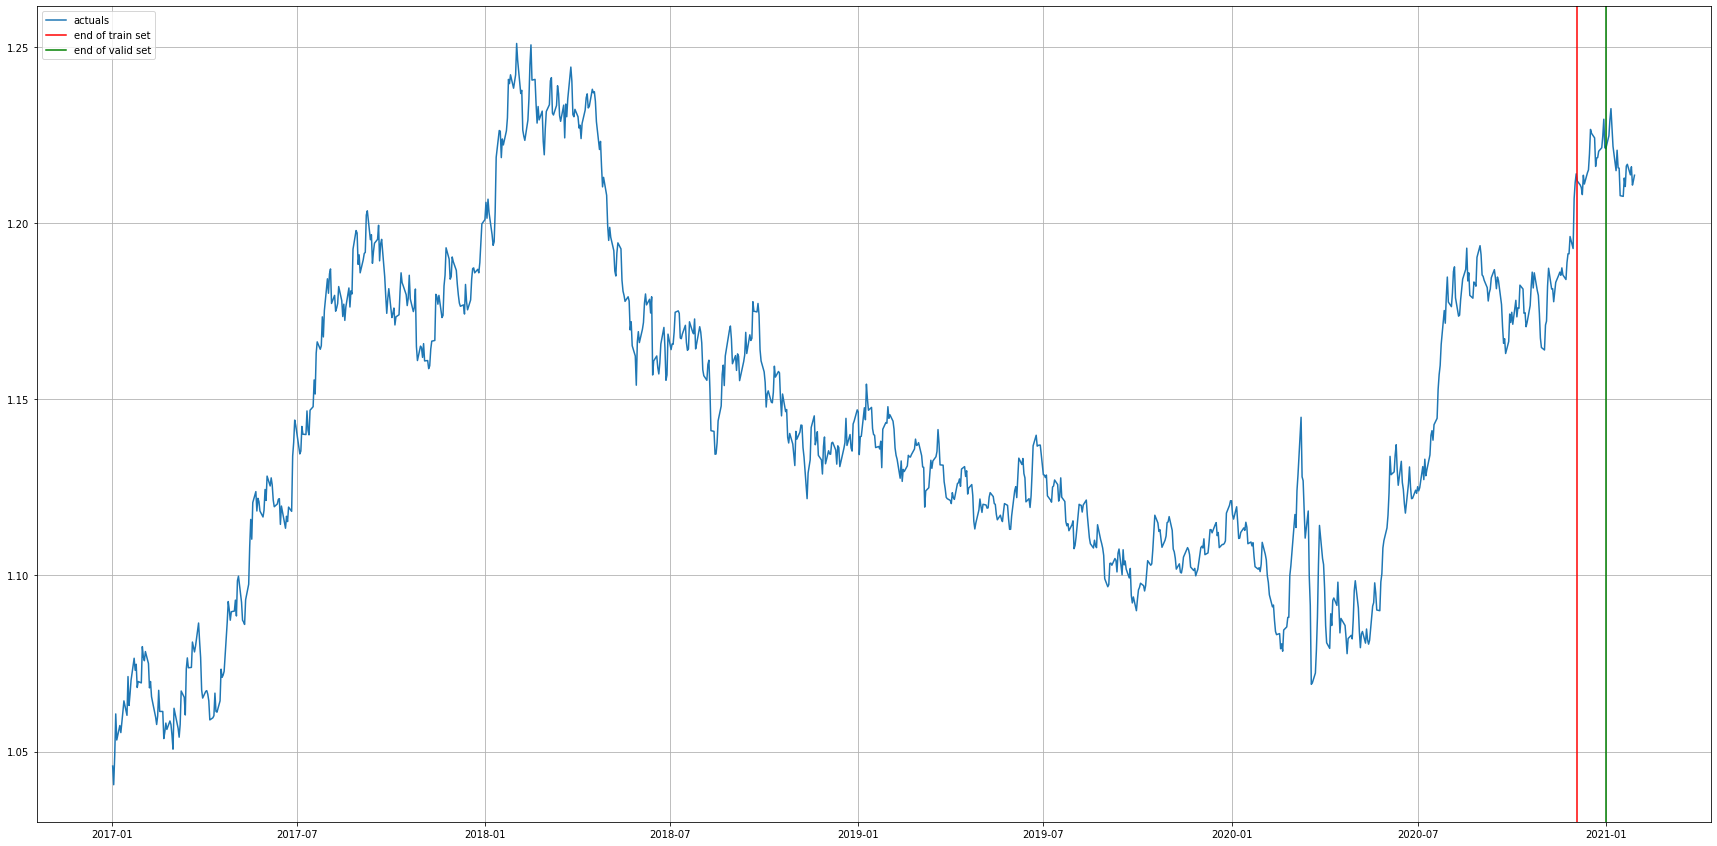

In [6]:
plt.figure(figsize=(30, 15))
plt.plot(inv_data)
plt.axvline(train.index[-1], color='r') # end of train dataset
plt.axvline(valid.index[-1], color='g') # end of valid dataset
plt.grid(which="both")
plt.legend(["actuals", "end of train set", "end of valid set"], loc="upper left")
plt.show()

# GluonTS Helpers

In [16]:
from gluonts.dataset.common import ListDataset


train_df = ListDataset([{'target': train_valid.Price.values, 
                         'start': train_valid.index[0]}], 
                       freq=train_valid.index.freq)

test_df = ListDataset([{'target': inv_data.Price.values, 
                        'start': inv_data.index[0]}],
                      freq=inv_data.index.freq)

In [17]:
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

from math import sqrt
from sklearn.metrics import mean_squared_error


def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = [50.0, 90.0]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(30, 15))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_wrapper(estimator, num_samples=100, verbose=True):
    """
    estimator: GluonTS estimator
    num_samples: number of sample paths we want for evaluation
    """
    predictor = estimator.train(train_df)
    forecast_it, ts_it = make_evaluation_predictions(
      dataset=test_df,
      predictor=predictor,
      num_samples=num_samples, 
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_entry = forecasts[0]
    ts_entry = tss[0]

    if verbose:
        print(f"Number of sample paths: {forecast_entry.num_samples}")
        print(f"Dimension of samples: {forecast_entry.samples.shape}")
        print(f"Start date of the forecast window: {forecast_entry.start_date}")
        print(f"Frequency of the time series: {forecast_entry.freq}")

        print(f"Mean of the future window:\n {forecast_entry.mean}")
        print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    
    plot_prob_forecasts(ts_entry, forecast_entry)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_df))
    return agg_metrics
    
def calculate_accuracy(actual, pred):
    rmse = sqrt(mean_squared_error(actual, pred))
    mape = abs(pred/actual - 1).mean()
    return {"MAPE": mape, "RMSE": rmse}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  


# Simple Feed Forward

In [107]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

ff_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=test_length,
    context_length=100, 
    freq="1B",
    trainer=Trainer(ctx="cpu",
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING:gluonts.trainer:Batch [13] of Epoch[0] gave NaN loss and it will be ignored


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 101.21it/s, epoch=20/20, avg_epoch_loss=-1.71]


Number of sample paths: 100
Dimension of samples: (100, 20)
Start date of the forecast window: 2021-01-04 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [1.2895321 1.1306514 1.2235503 1.2251468 1.2085785 1.2197267 1.251542
 1.21269   1.237915  1.2599694 1.2380043 1.1803447 1.2375894 1.2118617
 1.2159228 1.185725  1.2422557 1.1847908 1.2532791 1.2266074]
0.5-quantile (median) of the future window:
 [1.2780731 1.1319212 1.2202867 1.2255368 1.2148376 1.2306377 1.2562594
 1.211386  1.2388475 1.2628353 1.235517  1.1809514 1.2325721 1.2121443
 1.2166495 1.1864239 1.2420907 1.1870201 1.2567081 1.2230027]


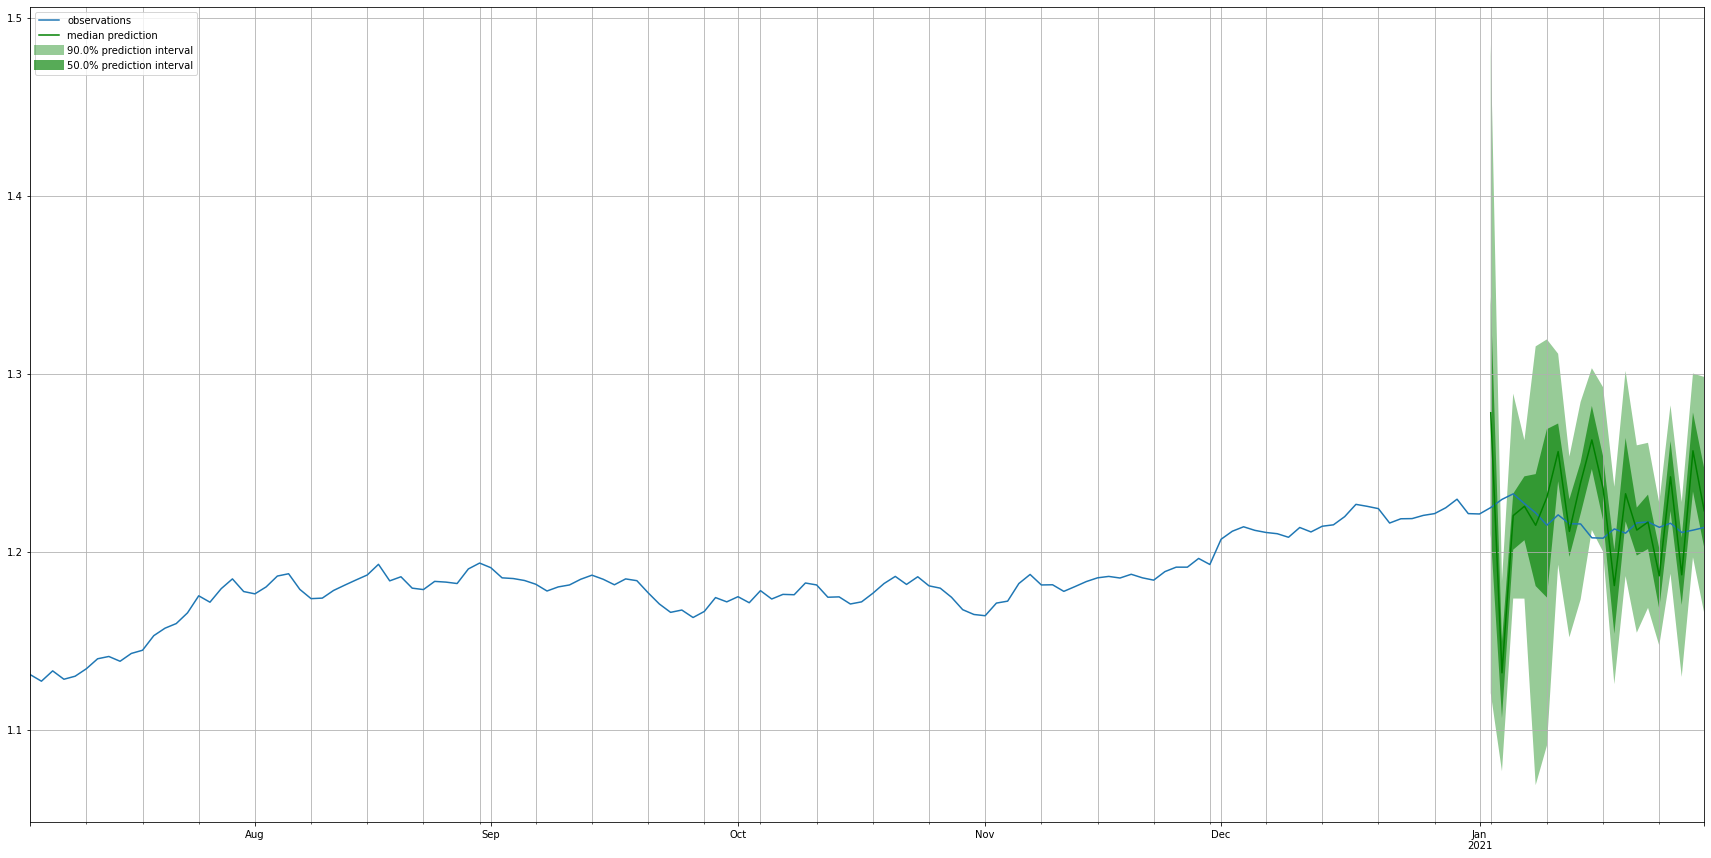

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


In [108]:
agg_metrics_simple_ff = gluonts_wrapper(ff_estimator)

# DeepAR

In [109]:
from gluonts.model.deepar import DeepAREstimator

deepar_estimator = DeepAREstimator(
    freq="1B",
    prediction_length=test_length,   
    trainer=Trainer(epochs=10) 
)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:03<00:00, 12.81it/s, epoch=10/10, avg_epoch_loss=-2.68]


Number of sample paths: 100
Dimension of samples: (100, 20)
Start date of the forecast window: 2021-01-04 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [1.2291464 1.2279739 1.2273409 1.2228351 1.2219054 1.220582  1.2202641
 1.2179749 1.2175559 1.2134295 1.214394  1.2148519 1.2144507 1.2102237
 1.2110016 1.2098941 1.2075766 1.2089115 1.2080461 1.2103679]
0.5-quantile (median) of the future window:
 [1.2294904 1.2247252 1.2279203 1.2223179 1.2203554 1.2210736 1.2184645
 1.2177619 1.2178606 1.2120941 1.2171524 1.2146477 1.2129328 1.2091175
 1.2097648 1.2096568 1.208508  1.2101005 1.2081398 1.2110069]


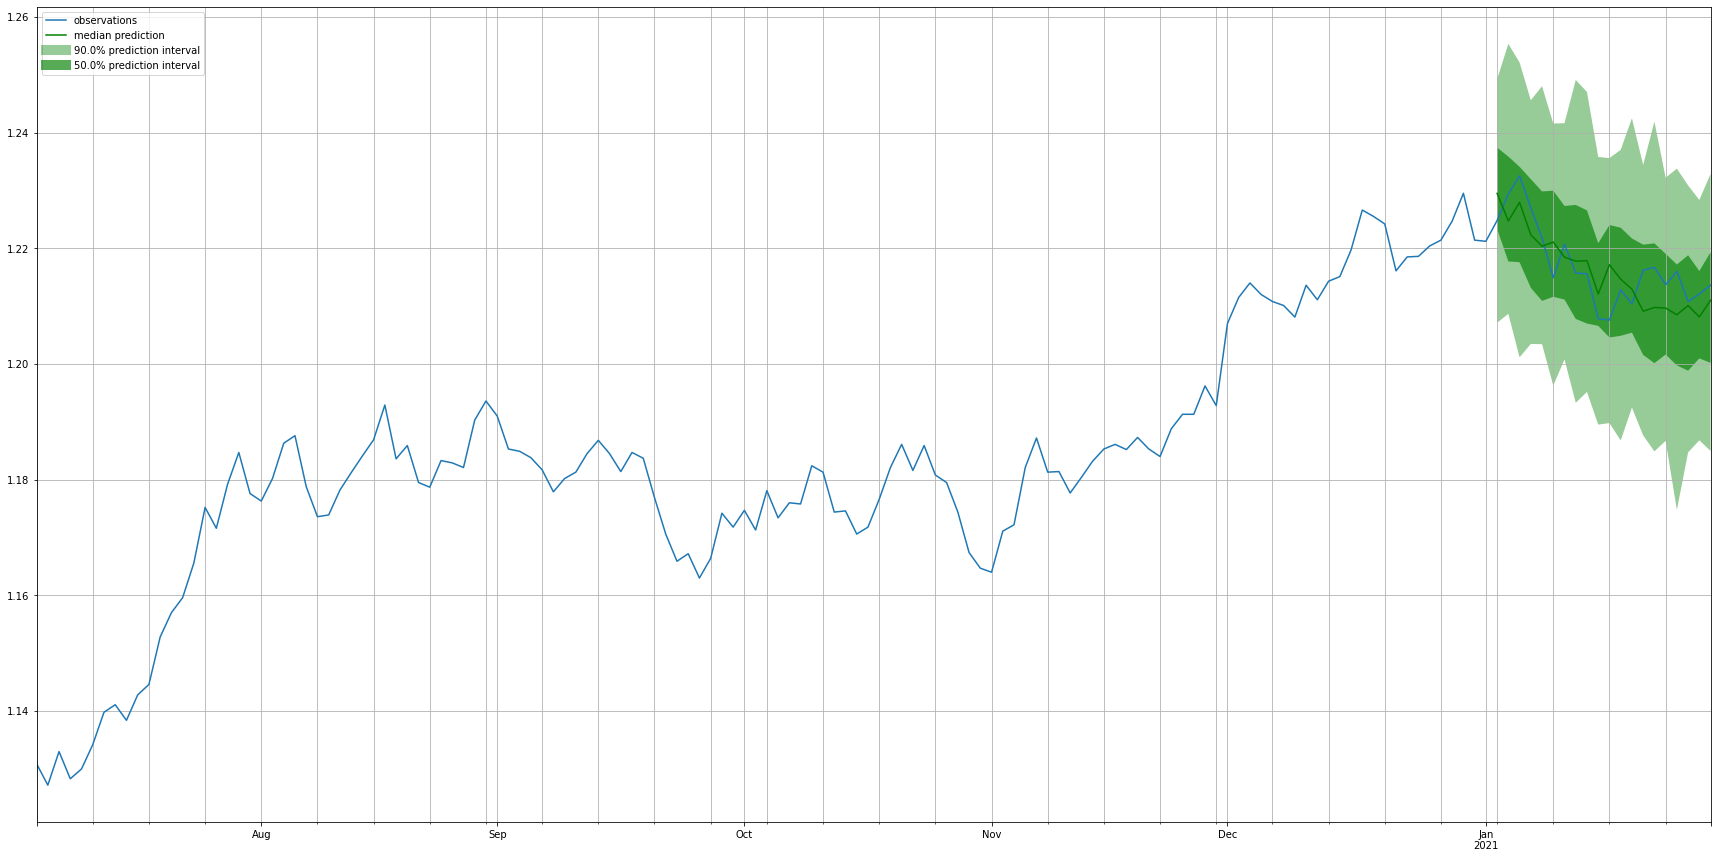

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


In [110]:
agg_metrics_deepar = gluonts_wrapper(deepar_estimator)

# Deep State

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s, epoch=20/20, avg_epoch_loss=-4.58]


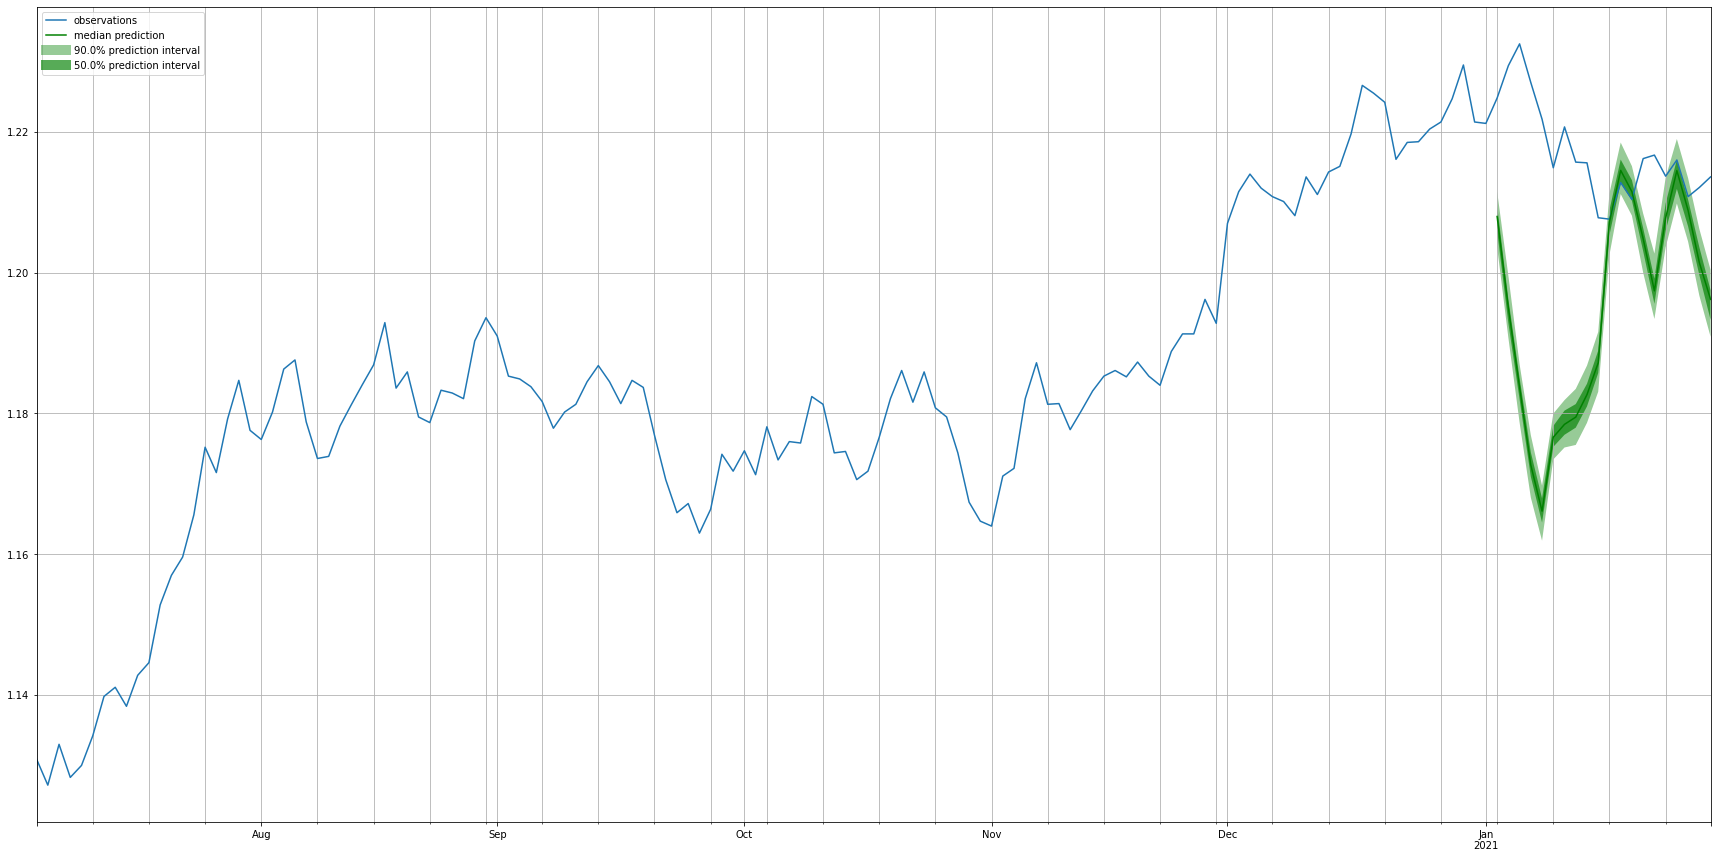

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


In [125]:
from gluonts.model.deepstate import DeepStateEstimator

deepstate_estimator = DeepStateEstimator(
    prediction_length=test_length,
    cardinality=[1],
    freq="1B",
    use_feat_static_cat=False,
    num_cells=50,
    num_layers=2,
    cell_type="lstm",
    past_length=500,
    trainer=Trainer(epochs=50))

agg_metrics_deepstate = gluonts_wrapper(deepstate_estimator, verbose=False)

# Deep Factor

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 72.18it/s, epoch=100/100, avg_epoch_loss=-5.9]


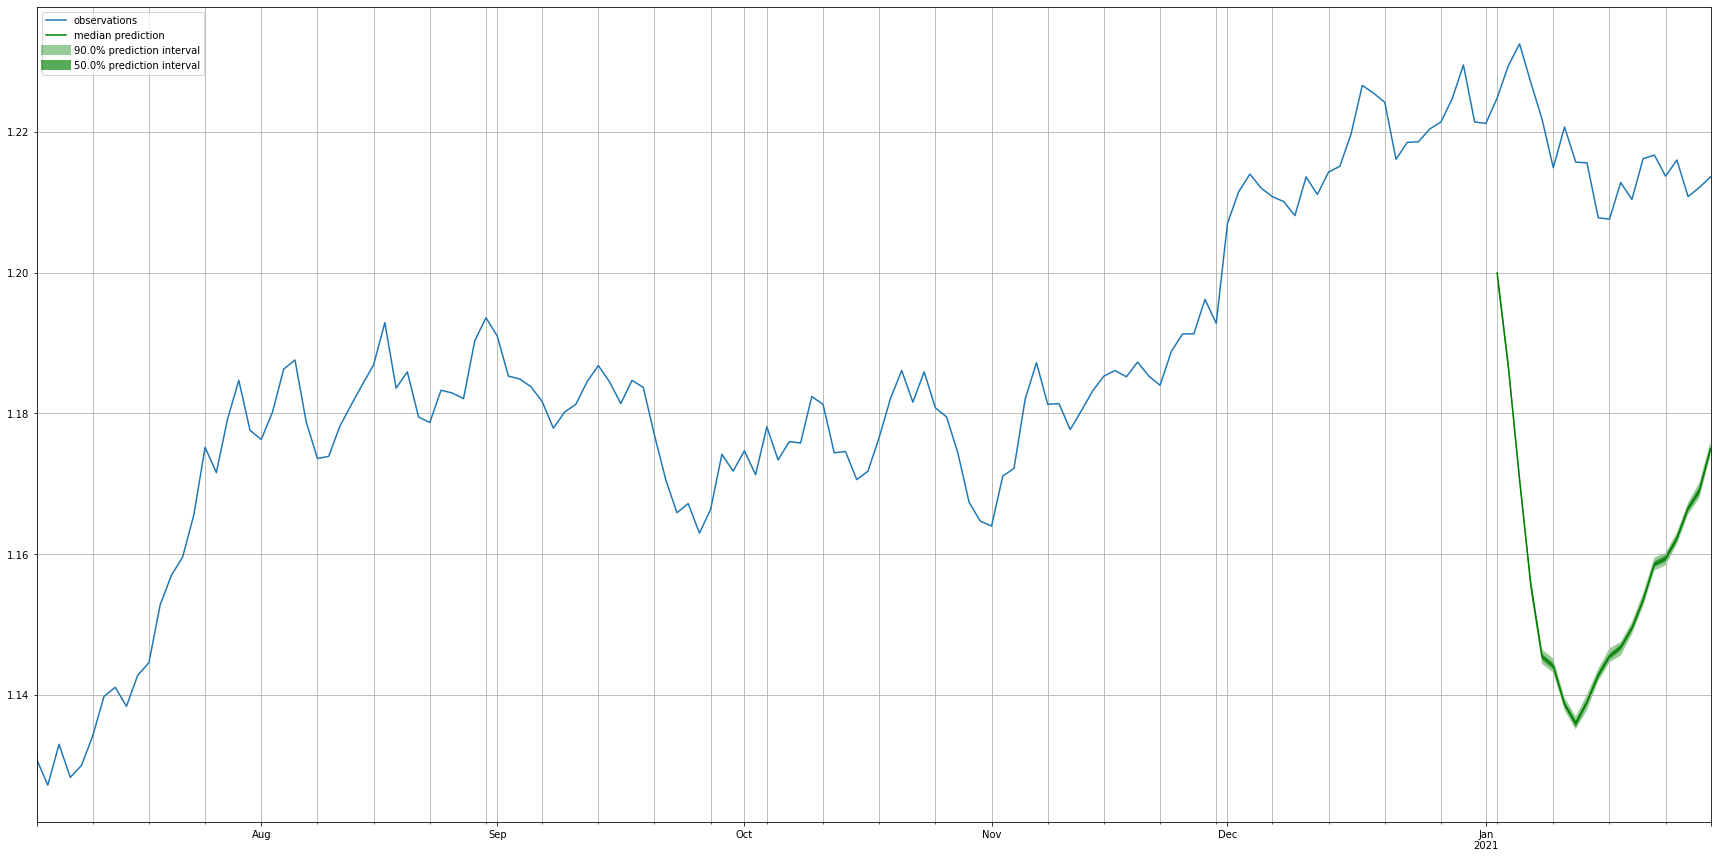

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


In [140]:
from gluonts.model.deep_factor import DeepFactorEstimator

deepfactor_estimator = DeepFactorEstimator(
    freq="1B",
    prediction_length=test_length,
    num_factors=50, #10
    num_hidden_global=20, # 50
    num_layers_global=2, # 1
    num_hidden_local=5, # 5 
    num_layers_local=1, # 1
    trainer=Trainer(epochs=100))

agg_metrics_deepfactor = gluonts_wrapper(deepfactor_estimator, verbose=False)

# ETS - Holt's Linear Trend

In [7]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [13]:
holt = Holt(train_valid).fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False, )
fcast1 = holt.forecast(test_length).rename("Holt's linear trend")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [20]:
agg_metrics_holt = calculate_accuracy(test["Price"], fcast1)

{'MAPE': 0.00524936379507589, 'RMSE': 0.007246046580491728}
{'MAPE': 0.005300547581983272, 'RMSE': 0.007304239661073174}
{'MAPE': 0.005245474635773156, 'RMSE': 0.0071967360532264645}
{'MAPE': 0.006308269955262147, 'RMSE': 0.0085247289260802}


# Neural Prophet

In [114]:
from neuralprophet import NeuralProphet

prophet_df = train_valid.reset_index()
prophet_df.columns = ["ds", "y"]

In [115]:
m = NeuralProphet(
    n_lags=test_length,
    n_forecasts=test_length,
    batch_size=64,
    epochs=50,
    learning_rate=0.1,
    ar_sparsity=0.2,
)
metrics = m.fit(prophet_df, freq='B')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[50/50]: 100%|██████████| 50/50 [00:04<00:00, 11.77it/s, SmoothL1Loss=0.00344, MAE=0.0131, RegLoss=0.0462]


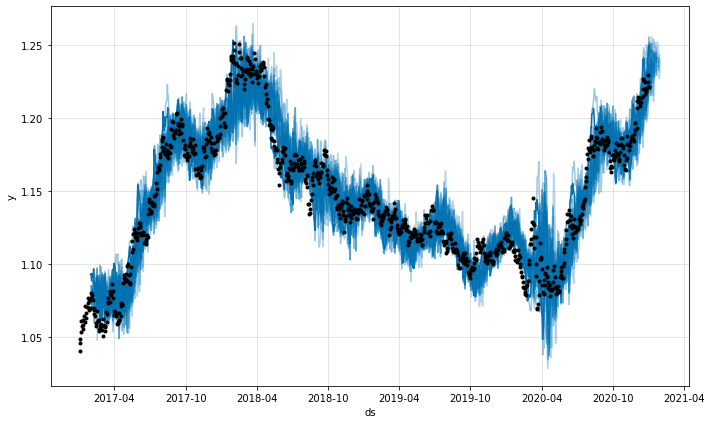

In [116]:
future = m.make_future_dataframe(prophet_df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

In [117]:
# fig_comp = m.plot_components(forecast)
# m = m.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
# fig_param = m.plot_parameters()

In [118]:
prophet_output = forecast[["ds", f"yhat{test_length}"]].iloc[-test_length:]
prophet_output.columns = ["Date", "Prediction"]
prophet_output = prophet_output.set_index("Date")

In [121]:
agg_metrics_prophet = calculate_accuracy(test["Price"], prophet_output["Prediction"])

# Comparison

In [122]:
df_metrics = pd.concat(
    [
        pd.DataFrame.from_dict(agg_metrics_simple_ff, orient='index').rename(columns={0: "Simple FF"}),
        pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"}),
        pd.DataFrame.from_dict(agg_metrics_deepstate, orient='index').rename(columns={0: "DeepState"}),
        pd.DataFrame.from_dict(agg_metrics_deepfactor, orient='index').rename(columns={0: "DeepFactor"}),        
        pd.DataFrame.from_dict(agg_metrics_prophet, orient='index').rename(columns={0: "NeuralProphet"}),       
        pd.DataFrame.from_dict(agg_metrics_holt, orient='index').rename(columns={0: "Holt's Linear"}),
    ], axis=1)
df_metrics.loc[["MAPE", "RMSE"]]

,Simple FF,DeepAR,DeepState,DeepFactor,NeuralProphet
MAPE,0.021455,0.003445,0.164916,0.059644,0.016897
RMSE,0.035463,0.004410,0.203060,0.074684,0.022691
